In [1]:
%run training_functions.ipynb

/home/ac.cdavies/.vnv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-04-04 15:21:47.943306: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743780107.957145  270724 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743780107.961355  270724 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743780107.973646  270724 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 

In, Out, get_ipython, exit, quit, open, accelerate, datasets, evaluate, math, np, peft, pickle, pytest, ipytest, pd, transformers, load_dataset, load_dataset_builder, get_dataset_split_names, get_dataset_config_names, LoftQConfig, LoraConfig, get_peft_model, AutoModelForCausalLM, AutoTokenizer, TrainingArguments, Trainer, SFTTrainer, SFTConfig, @py_builtins, @pytest_ar, model_from_pkl, map_data, print_trainable_parameters, metric, comp_metrics_output, compute_metrics, make_trainer, get_dataframe, get_training_output, 

## Imported Functions
1. model_from_pkl(model): extracts ML model from pkl file
2. map_data(data, model, tokenizer): performs preprocessing/tokenization on data
3. make_trainer(m_model, train_data, test_data, config, args): creates training object with model, training arguments, train/test data, a configuration, and evaluation function
4. compute_metrics(eval_pred): used in the trainer, calculates prediction accuracy/validation loss
5. get_training_output(trainer, keys: list): extracts data from training logs
6. get_dataframe(training_output: list, strategy): used in get_training_output, puts training data into dataframe/graph form

In [5]:
lla_321, lla_321_tokenizer=model_from_pkl("Llama-3.2-1B-Instruct")

In [6]:
lla_323, lla_323_tokenizer=model_from_pkl("Llama-3.2-3B")

In [7]:
l_tokenized_genome_samples=map_data(ds_gs, lla_321, lla_321_tokenizer)

Map: 100%|███████████████████| 50/50 [00:02<00:00, 21.88 examples/s]


In [8]:
l_tokenized_stage1_train=map_data(ds_gst1_train, lla_321, lla_321_tokenizer)
l_tokenized_stage1_test=map_data(ds_gst1_test, lla_321, lla_321_tokenizer)

Map: 100%|███████████████████| 50/50 [00:01<00:00, 28.53 examples/s]


In [9]:
l_tokenized_stage2_train=map_data(ds_gst2_train, lla_321, lla_321_tokenizer)
l_tokenized_stage2_test=map_data(ds_gst2_test, lla_321, lla_321_tokenizer)

Map: 100%|███████████████████| 50/50 [00:01<00:00, 27.81 examples/s]


In [10]:
# to fine-tune with LoRA, instantiate a base model (as above)
# create LoraConfig where LoRA-specific parameters are defined
config=LoraConfig(
    #inference_mode=False,
    r=8, #rank of update matrices, lower value results in smaller matrices with fewer parameters
    lora_alpha=16, #LoRA scaling factor
    task_type="CAUSAL_LM",
    lora_dropout=0.1, # dropout probability of LoRA layers
    bias="none", # specifies if bias parameters should be trained
    #modules_to_save=["decode_head"] #models apart from LoRA layers that are trainable
)

In [11]:
lla_lora_model=get_peft_model(lla_321, config)
print_trainable_parameters(lla_lora_model)

trainable params: 851968 || all params: 1236666368 || trainable%: 0.07


In [12]:
l_trainer=make_trainer(lla_lora_model, l_tokenized_stage1_train, l_tokenized_stage1_test, config,
                          SFTConfig(output_dir="test_trainer", eval_strategy="epoch",
                                    logging_strategy="steps",
                                    logging_steps=2))

Truncating train dataset: 100%|█| 500/500 [00:00<00:00, 1163.05 exam
Truncating eval dataset: 100%|█| 50/50 [00:00<00:00, 1050.17 example


In [13]:
l_trainer.train() #same arguments as m_trainer

/home/ac.cdavies/.vnv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.671200,2.664509,0.000605
2,0.668800,2.651023,0.000937
3,0.671500,2.646279,0.001016


/home/ac.cdavies/.vnv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/ac.cdavies/.vnv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/ac.cdavies/.vnv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
IOStream.flush timed out


TrainOutput(global_step=48, training_loss=0.6726996973156929, metrics={'train_runtime': 1100.248, 'train_samples_per_second': 1.363, 'train_steps_per_second': 0.044, 'total_flos': 8976366305280000.0, 'train_loss': 0.6726996973156929})

,loss,eval_loss,eval_accuracy
epoch,,,
1.0,0.6712,2.664509,0.000605
2.0,0.6688,2.651023,0.000937
3.0,0.6715,2.646279,0.001016


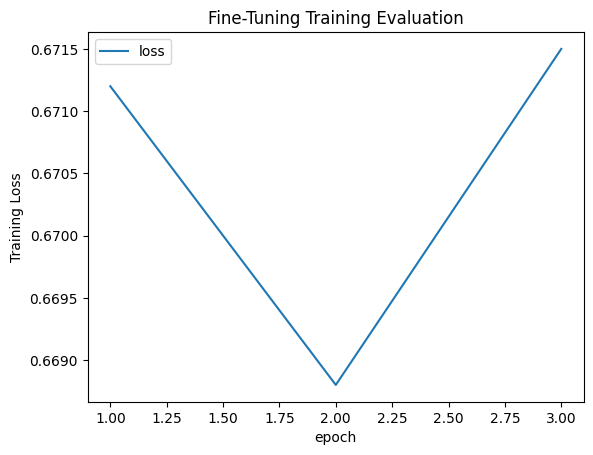

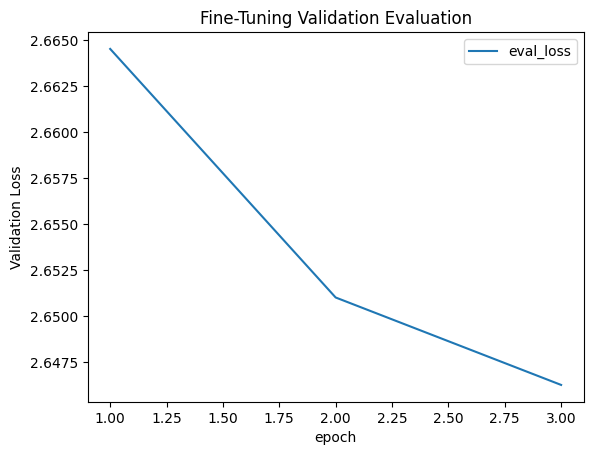

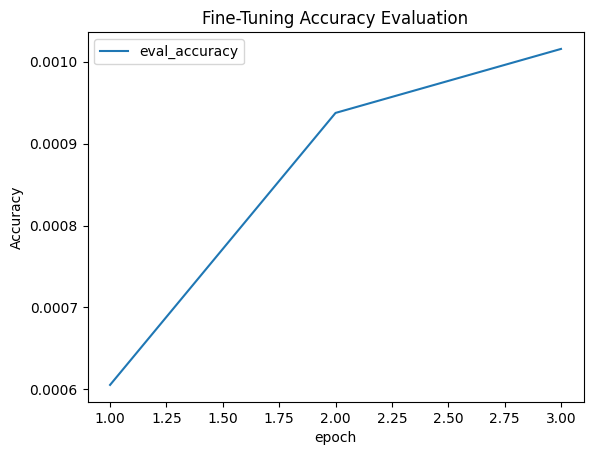

In [14]:
output=get_training_output(l_trainer, ['loss', 'eval_loss', 'eval_accuracy'])
output

In [15]:
l2_trainer = make_trainer(lla_lora_model, l_tokenized_stage1_train, l_tokenized_stage1_test, config,
                          SFTConfig(output_dir="test_trainer", eval_strategy="steps",
                                    logging_strategy="steps",
                                    logging_steps=6))

In [16]:
l2_trainer.train() 

/home/ac.cdavies/.vnv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
6,0.666200,2.637327,0.001484
12,0.666900,2.631176,0.002012
18,0.660800,2.627082,0.001992
24,0.663300,2.623627,0.001953
30,0.662300,2.621457,0.001660
36,0.660700,2.619833,0.001523
42,0.658400,2.618192,0.001348
48,0.661300,2.617988,0.001152


/home/ac.cdavies/.vnv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/ac.cdavies/.vnv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/ac.cdavies/.vnv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/ac.cdavies/.vnv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/ac.cdavies/.vnv/lib/python3.12/site-packages/torch

TrainOutput(global_step=48, training_loss=0.6624943763017654, metrics={'train_runtime': 2869.3889, 'train_samples_per_second': 0.523, 'train_steps_per_second': 0.017, 'total_flos': 8976366305280000.0, 'train_loss': 0.6624943763017654})

,loss,eval_loss,eval_accuracy
steps,,,
6,0.6662,2.637327,0.001484
12,0.6669,2.631176,0.002012
18,0.6608,2.627082,0.001992
24,0.6633,2.623627,0.001953
30,0.6623,2.621457,0.001660
36,0.6607,2.619833,0.001523
42,0.6584,2.618192,0.001348
48,0.6613,2.617988,0.001152


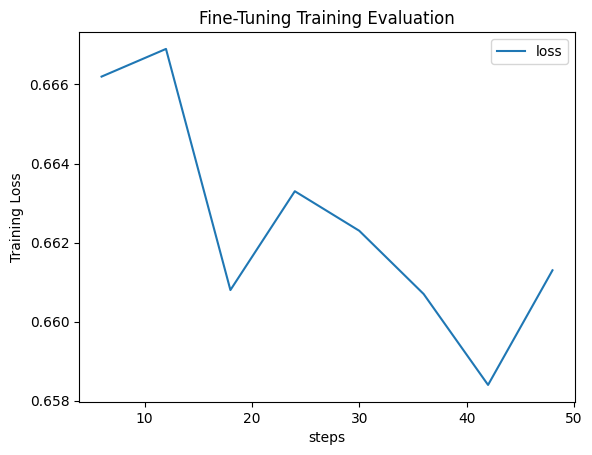

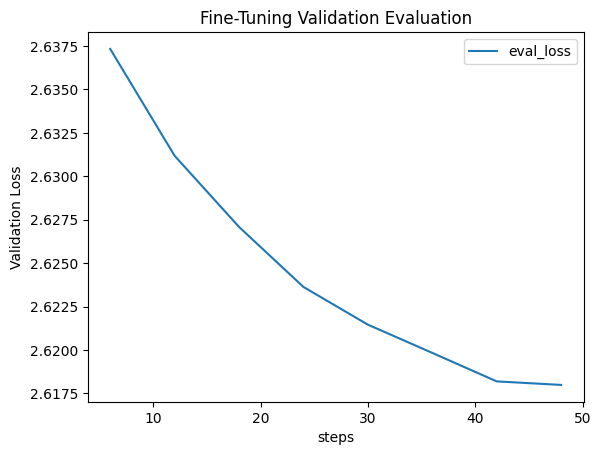

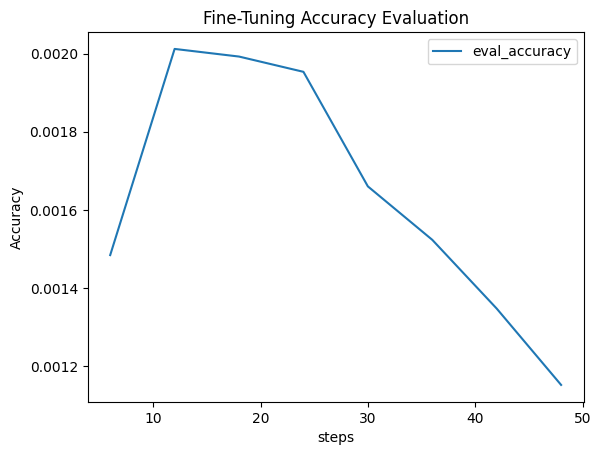

In [17]:
output=get_training_output(l2_trainer, ['loss', 'eval_loss', 'eval_accuracy'])
output

In [18]:
l_trainer.model.save_pretrained('./fine_tuned/lla/')
l2_trainer.model.save_pretrained('./fine_tuned/lla2/')

In [19]:
l_trainer.processing_class.save_pretrained('./fine_tuned/lla_token/')
l2_trainer.processing_class.save_pretrained('./fine_tuned/lla2_token/')

('./fine_tuned/lla2_token/tokenizer_config.json',
 './fine_tuned/lla2_token/special_tokens_map.json',
 './fine_tuned/lla2_token/tokenizer.json')